In [1]:
# Import Libraries
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithZScore, NormalPredictor
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
from surprise.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
from dmba import plotDecisionTree, classificationSummary, regressionSummary

# Problem: Product ratings
Sephora asks customers to rate their purchased products online. Sephora is interested in building a recommendation system that would provide customers  with recommendations for additional products after they a customer has added an item into their cart.

# Load Data

In [2]:
# Get  current working directory
project_root = os.getcwd()
datasets = os.path.join(project_root, "datasets/")

# Define the dtype for column 1 to avoid mixed types
dtype_dict = {1: str}

# load the Data
product_info = pd.read_csv(datasets + "product_info.csv")
#product_info = pd.read_csv(datasets + "product_info.csv", index_col="product_id")
# Reviews
reviews_250 = pd.read_csv(datasets + "reviews_0-250.csv", dtype=dtype_dict)
reviews_500 = pd.read_csv(datasets + "reviews_250-500.csv", dtype=dtype_dict)
reviews_750 = pd.read_csv(datasets + "reviews_500-750.csv", dtype=dtype_dict)
reviews_1250 = pd.read_csv(datasets + "reviews_750-1250.csv", dtype=dtype_dict)
reviews_end = pd.read_csv(datasets + "reviews_1250-end.csv", dtype=dtype_dict)

# Review Contents
print("product_info shape:", product_info.shape)
print("reviews_250 shape:", reviews_250.shape)
print("reviews_500 shape:", reviews_500.shape)
print("reviews_750 shape:", reviews_750.shape)
print("reviews_1250 shape:", reviews_1250.shape)
print("reviews_end shape:", reviews_end.shape)

# Concatenate the DataFrames and remove duplicates
all_reviews = pd.concat([
    reviews_250, reviews_500, reviews_750, 
    reviews_1250, reviews_end
], ignore_index=True).drop_duplicates()

product_info shape: (8494, 27)
reviews_250 shape: (602130, 19)
reviews_500 shape: (206725, 19)
reviews_750 shape: (116262, 19)
reviews_1250 shape: (119317, 19)
reviews_end shape: (49977, 19)


In [3]:
# Verify the data
print("Product Info Shape:", product_info.shape)
print("\nProduct Info Columns:", product_info.columns.tolist())
print("\nProduct Info Sample:")
display(product_info.head(2))

print("\nAll Reviews Shape:", all_reviews.shape)
print("\nAll Reviews Columns:", all_reviews.columns.tolist())
print("\nAll Reviews Sample:")
display(all_reviews.head(2))

Product Info Shape: (8494, 27)

Product Info Columns: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']

Product Info Sample:


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0



All Reviews Shape: (1094411, 19)

All Reviews Columns: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd']

All Reviews Sample:


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


# Define helper functions

In [4]:
# Data Preprocessing
def preprocess_data(product_info, all_reviews):
    # Merge product info with reviews
    merged_df = all_reviews.merge(
        product_info[['product_id', 'product_name', 'brand_name']], 
        on='product_id', 
        how='left'
    )
    
    # Check for missing values
    print("Missing values:")
    print(merged_df.isnull().sum())
    
    # Remove rows with missing values
    # merged_df = merged_df.dropna()
    
    # Create mapping dictionaries for users and items
    user_mapper = {id_: idx for idx, id_ in enumerate(merged_df['author_id'].unique())}
    item_mapper = {id_: idx for idx, id_ in enumerate(merged_df['product_id'].unique())}
    
    # Create reverse mappers for later use
    reverse_user_mapper = {v: k for k, v in user_mapper.items()}
    reverse_item_mapper = {v: k for k, v in item_mapper.items()}
    
    # Transform IDs to numerical indices
    merged_df['user_idx'] = merged_df['author_id'].map(user_mapper)
    merged_df['item_idx'] = merged_df['product_id'].map(item_mapper)
    
    return merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper

In [5]:
# Revised Exploratory Data Analysis
def perform_eda(merged_df):
    # Plot the distribution of ratings
    plt.figure(figsize=(12, 6))
    sns.histplot(merged_df['rating'], bins=5)
    plt.title('Distribution of Ratings')
    plt.show()
    
    print("\nRating Statistics:")
    print(merged_df['rating'].describe())
    
    # Plot the top 10 brand names
    plt.figure(figsize=(12, 6))
    category_counts = merged_df['brand_name_x'].value_counts().head(10)
    sns.barplot(x=category_counts.values, y=category_counts.index)
    plt.title('Top 10 Brand Names for Skincare')
    plt.show()
    
    # Display user activity statistics
    print("\nUser Activity Statistics:")
    user_activity = merged_df.groupby('author_id').size()
    user_activity_stats = user_activity.describe()
    print(user_activity_stats)
    
    # Get the maximum number of reviews submitted by any user
    max_reviews_per_user = user_activity.max()
    
    # Plot the distribution of reviews per user
    plt.figure(figsize=(10, 6))
    sns.histplot(user_activity, bins=30)
    plt.title('Distribution of Reviews per User')
    plt.xlabel('Number of Reviews')
    plt.xlim(0, max_reviews_per_user)  # Limit the x-axis to the max number of reviews
    plt.show()
    
    # Calculate and display the top 10 users with the most reviews
    top_10_users = user_activity.sort_values(ascending=False).head(10)
    print("\nTop 10 Users with the Highest Number of Reviews Submitted:")
    print(top_10_users)

In [6]:
# Revised Model Selection and Training
def train_and_evaluate_models(merged_df):
    # Check if merged_df has the required columns
    if not {'user_idx', 'item_idx', 'rating'}.issubset(merged_df.columns):
        raise ValueError("merged_df must contain 'user_idx', 'item_idx', and 'rating' columns.")
    
    # Ensure the data types are correct
    merged_df['user_idx'] = merged_df['user_idx'].astype(int)
    merged_df['item_idx'] = merged_df['item_idx'].astype(int)
    merged_df['rating'] = merged_df['rating'].astype(float)

    # Create a Reader for the rating scale
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)
    
    # Split into training and test set
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

    # Initialize models with memory-efficient similarity algorithms
    models = {
        'KNNWithZScore': KNNWithZScore(
            sim_options={
                'name': 'pearson_baseline',  # Use Pearson baseline for memory efficiency
                'user_based': False  # Switch to item-based filtering
            },
            k=40  # Limit the number of neighbors
        )
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(trainset)
        predictions = model.test(testset)
        results[name] = predictions
    
    return results, trainset, testset

In [7]:
# Hyperparameter Tuning with Save Point
def tune_hyperparameters(data, save_path="tuning_results.csv"):
    param_grid = {
        'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005, 0.007],
        'reg_all': [0.4, 0.6, 0.8]
    }
    
    print("Performing Grid Search...")
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    
    print("Performing Random Search...")
    rs = RandomizedSearchCV(SVD, param_grid, n_iter=5, measures=['rmse', 'mae'], cv=3)
    rs.fit(data)
    
    # Collect the best parameters for RMSE from both searches
    best_params = {
        "grid_search_best_params": gs.best_params['rmse'],
        "random_search_best_params": rs.best_params['rmse']
    }
    
    # Convert to DataFrame and save to CSV
    results_df = pd.DataFrame(best_params).T
    results_df.to_csv(save_path, index=False)
    
    print(f"Results saved to {save_path}")
    return gs.best_params['rmse'], rs.best_params['rmse']

#### Top-N Recommendations

In [8]:
# Get Top-N Recommendations
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

## Evaluation

In [9]:
# Evaluation Metrics
def evaluate_model(predictions):
    rmse = np.sqrt(np.mean([(p.r_ui - p.est)**2 for p in predictions]))
    
    # Convert predictions to binary (like/dislike)
    actual = [1 if p.r_ui >= 3.5 else 0 for p in predictions]
    predicted = [1 if p.est >= 3.5 else 0 for p in predictions]

    return rmse, actual, predicted

def main(product_info, all_reviews):
    print("1. Preprocessing data...")
    merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper = preprocess_data(product_info, all_reviews)
    
    print("\n2. Performing Exploratory Data Analysis...")
    perform_eda(merged_df)
    
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)
    
    print("\n3. Tuning hyperparameters...")
    best_params_gs, best_params_rs = tune_hyperparameters(data)
    print("Best parameters (Grid Search):", best_params_gs)
    print("Best parameters (Random Search):", best_params_rs)
    
    print("\n4. Training and evaluating models...")
    results, trainset, testset = train_and_evaluate_models(merged_df)
    
    print("\n5. Model Evaluation Results:")
    for name, predictions in results.items():
        rmse, cm = evaluate_model(predictions)
        print(f"\nResults for {name}:")
        print(f"RMSE: {rmse}")
        print("Confusion Matrix:")
        print(cm)
        
        # Get top-N recommendations for a few users
        top_n = get_top_n(predictions, n=5)
        print(f"\nTop-5 recommendations for first few users ({name}):")
        for user_idx, user_ratings in list(top_n.items())[:3]:
            original_user_id = reverse_user_mapper[user_idx]
            print(f"User {original_user_id}:")
            for item_idx, est in user_ratings:
                original_item_id = reverse_item_mapper[item_idx]
                product_name = product_info[product_info['product_id'] == original_item_id]['product_name'].values[0]
                print(f"  {product_name} (predicted rating: {est:.2f})")

## Data Preprocessing

The following function...

In [10]:
# Preprocess data
merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper = preprocess_data(product_info, all_reviews)
print("Merged DataFrame Shape:", merged_df.shape)
display(merged_df.head())

Missing values:
Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name_x                   0
brand_name_x                     0
price_usd                        0
product_name_y                   0
brand_name_y                     0
dtype: int64
Merged DataFrame Shape: (1094411, 23)


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,...,skin_type,hair_color,product_id,product_name_x,brand_name_x,price_usd,product_name_y,brand_name_y,user_idx,item_idx
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,...,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0,Gentle Hydra-Gel Face Cleanser,NUDESTIX,0,0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,...,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,1,1
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,...,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,2,1
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,...,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,3,1
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",...,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,4,1


## Exploratory Data Analysis

The following function...

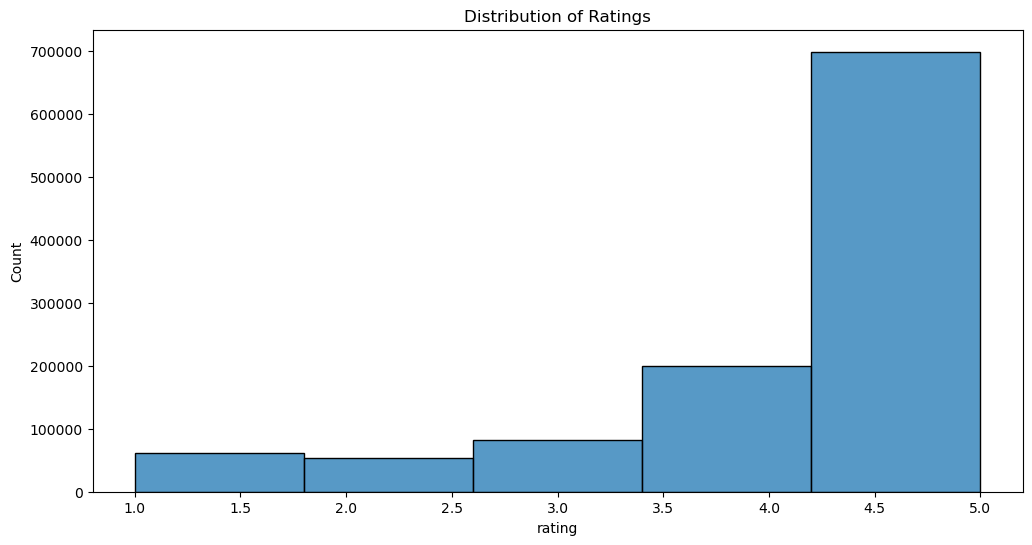


Rating Statistics:
count    1.094411e+06
mean     4.299158e+00
std      1.149444e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


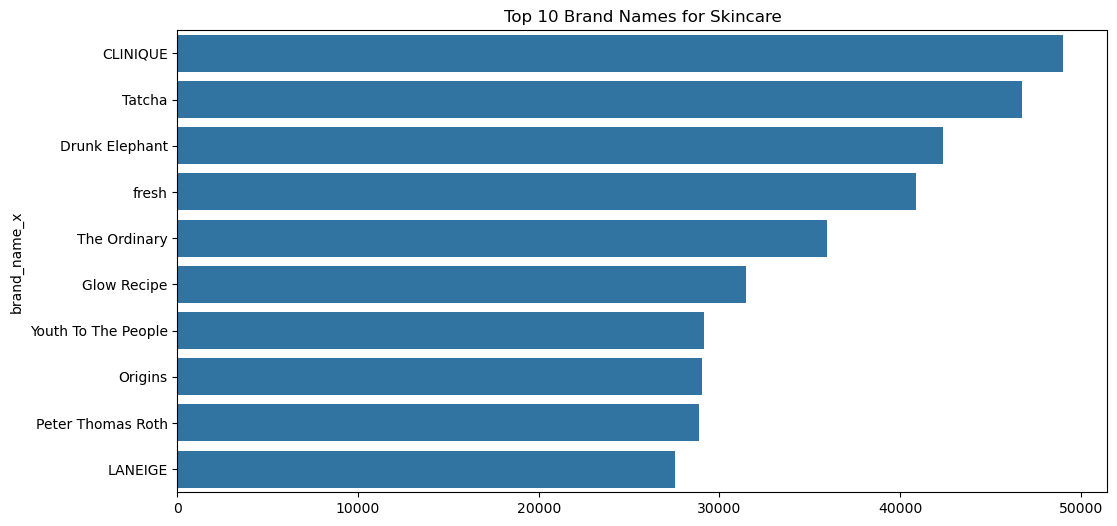


User Activity Statistics:
count    503216.000000
mean          2.174833
std           3.414628
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         292.000000
dtype: float64


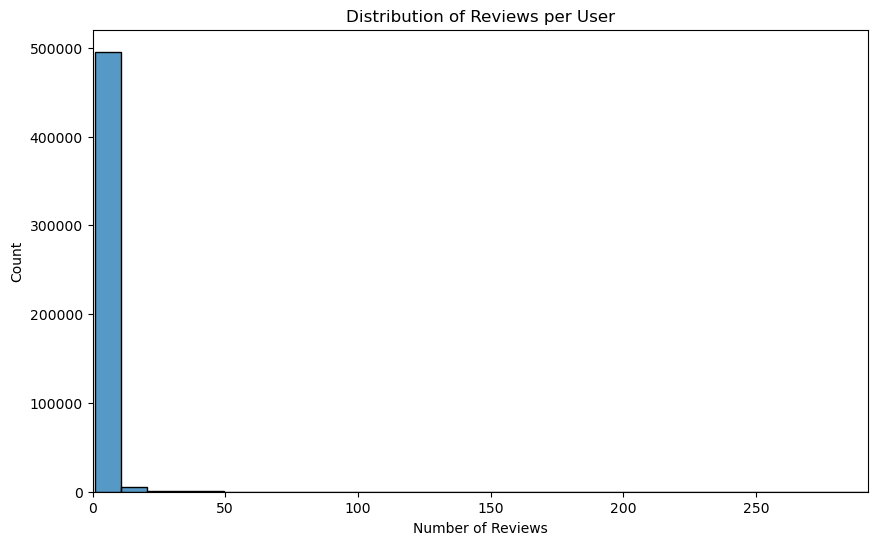


Top 10 Users with the Highest Number of Reviews Submitted:
author_id
1696370280     292
1288462295     210
1930716686     155
7375781965     155
2330399812     151
5060164185     151
1738022745     136
1492711942     135
10690040573    131
12640060683    118
dtype: int64


In [11]:
# Perform EDA
perform_eda(merged_df)

#### Prepare data for Surprise library

In [12]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)

## Hyperparameter Tuning

This function..

In [13]:
# Hyperparameter tuning
gs_best_params, rs_best_params = tune_hyperparameters(data)
print("Best parameters (Grid Search):", gs_best_params)
print("Best parameters (Random Search):", rs_best_params)

## Model Evaluation

In [14]:
# Train and evaluate models
try:
    results, trainset, testset = train_and_evaluate_models(merged_df)
except Exception as e:
    print(f"An error occurred: {e}")


Training KNNWithZScore...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [15]:
# Evaluate results and get recommendations
for name, predictions in results.items():
    rmse, actual, predicted = evaluate_model(predictions)
    print(f"\n{name} Results (Validation Data):")
    print(f"RMSE: {rmse}")
    classes = ['LIKE', 'DISLIKE']
    classificationSummary(actual, predicted, class_names=classes)
    
    # Get top-N recommendations for a few users
    top_n = get_top_n(predictions, n=5)
    print(f"\nTop-5 recommendations for first few users ({name}):")
    for user_idx, user_ratings in list(top_n.items())[:3]:
        original_user_id = reverse_user_mapper[user_idx]
        print(f"User {original_user_id}:")
        for item_idx, est in user_ratings:
            original_item_id = reverse_item_mapper[item_idx]
            product_name = product_info[product_info['product_id'] == original_item_id]['product_name'].values[0]
            print(f"  {product_name} (predicted rating: {est:.2f})")


KNNWithZScore Results (Validation Data):
RMSE: 1.0658207689604917
Confusion Matrix (Accuracy 0.8396)

        Prediction
 Actual    LIKE DISLIKE
   LIKE   14188   34786
DISLIKE    9098  215531

Top-5 recommendations for first few users (KNNWithZScore):
User 5967422089:
  Protini Polypeptide Firming Refillable Moisturizer (predicted rating: 5.00)
User 5477626830:
  Grape Water Moisturizing Face Mist (predicted rating: 3.81)
User 7134624510:
  Mini Rare Earth Deep Pore Minimizing Cleansing Clay Mask (predicted rating: 4.30)
  Rare Earth Deep Pore Minimizing Cleansing Clay Mask (predicted rating: 4.30)
